In [ ]:
install.packages("reshape2")
install.packages("ggplot2")
install.packages("dplyr")
install.packages("signal")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("readxl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Dataset dimensions: 682 507 
Column names: sample_id channel_id subject label image granularity ...
Number of time points: 501 
Number of unique samples: 11 
Number of unique channels: 62 
Channels with highest mean activity:
# A tibble: 5 × 2
  channel_id mean_activity
       <dbl>         <dbl>
1          2    0.0000185 
2          1    0.0000183 
3          0    0.0000159 
4          4    0.0000118 
5          5    0.00000993


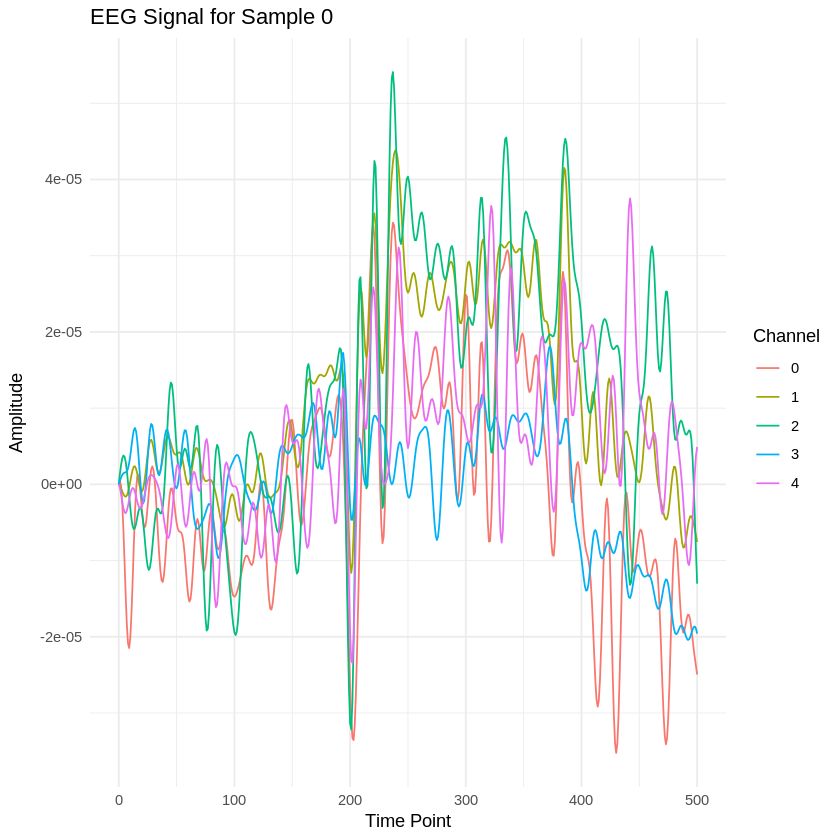

In [ ]:
library(ggplot2)
library(reshape2)
library(dplyr)
library(signal)
library(readxl)


eeg_data <- read_excel("/content/eeg_data_first10_samples.xlsx")


cat("Dataset dimensions:", dim(eeg_data), "\n")
cat("Column names:", head(colnames(eeg_data)), "...\n")


time_cols <- grep("time_", colnames(eeg_data), value=TRUE)
cat("Number of time points:", length(time_cols), "\n")


cat("Number of unique samples:", length(unique(eeg_data$sample_id)), "\n")
cat("Number of unique channels:", length(unique(eeg_data$channel_id)), "\n")


# Channel analysis - calculate average activity per channel
channel_summary <- eeg_data %>%
  group_by(channel_id) %>%
  summarize(across(all_of(time_cols), mean)) %>%
  mutate(mean_activity = rowMeans(select(., all_of(time_cols))))

cat("Channels with highest mean activity:\n")
print(channel_summary %>%
      arrange(desc(mean_activity)) %>%
      select(channel_id, mean_activity) %>%
      head(5))

# Explicitly specify which filter function to use
plot_sample <- function(sample_id, max_channels=5) {
  sample_data <- dplyr::filter(eeg_data, sample_id == !!sample_id)
  channels_to_plot <- unique(sample_data$channel_id)[1:min(max_channels, length(unique(sample_data$channel_id)))]

  # Reshape for plotting
  plot_data <- sample_data %>%
    dplyr::filter(channel_id %in% channels_to_plot) %>%
    select(channel_id, all_of(time_cols)) %>%
    melt(id.vars="channel_id", variable.name="time_point", value.name="amplitude") %>%
    mutate(time_value = as.numeric(gsub("time_", "", time_point)))

  # Create plot
  ggplot(plot_data, aes(x=time_value, y=amplitude, color=factor(channel_id))) +
    geom_line() +
    labs(title=paste("EEG Signal for Sample", sample_id),
         x="Time Point", y="Amplitude", color="Channel") +
    theme_minimal()
}

# Try plotting again
plot_sample(0)

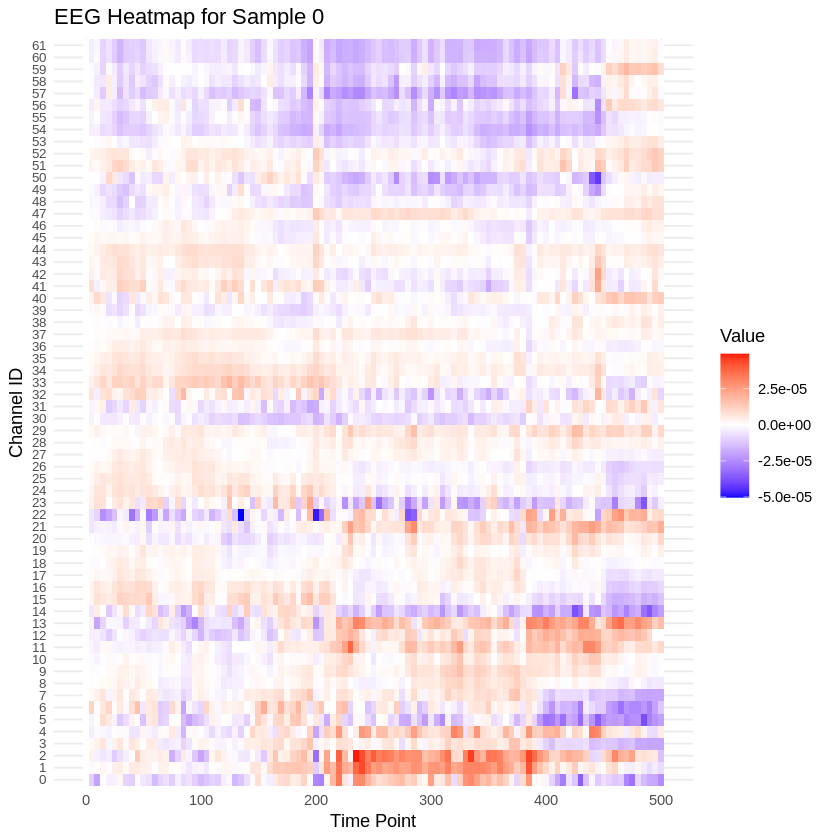

In [ ]:
# Simplified EEG Analysis in R

# 1. Simple descriptive statistics for channels
simple_channel_stats <- function() {
  # Calculate basic statistics for each channel
  channel_stats <- eeg_data %>%
    group_by(channel_id) %>%
    summarize(
      mean_value = mean(unlist(select(., all_of(time_cols)))),
      min_value = min(unlist(select(., all_of(time_cols)))),
      max_value = max(unlist(select(., all_of(time_cols)))),
      std_dev = sd(unlist(select(., all_of(time_cols))))
    )

  # Print statistics
  print(channel_stats)

  # Simple bar chart of mean values by channel
  ggplot(channel_stats, aes(x=factor(channel_id), y=mean_value)) +
    geom_bar(stat="identity", fill="skyblue") +
    labs(title="Mean EEG Value by Channel",
         x="Channel ID", y="Mean Value") +
    theme_minimal()
}

# 2. Simple time series comparison between subjects
compare_subjects <- function(max_subjects=3, channel_id=1) {
  if("subject" %in% colnames(eeg_data)) {
    # Get unique subjects (limited to max_subjects)
    subjects <- unique(eeg_data$subject)[1:min(max_subjects, length(unique(eeg_data$subject)))]

    # Filter data for selected subjects and channel
    subject_data <- eeg_data %>%
      filter(subject %in% subjects, channel_id == !!channel_id) %>%
      select(subject, sample_id, all_of(time_cols))

    # Reshape for plotting
    plot_data <- subject_data %>%
      group_by(subject) %>%
      summarize(across(all_of(time_cols), mean)) %>%
      pivot_longer(cols=all_of(time_cols), names_to="time_point", values_to="value") %>%
      mutate(time_value = as.numeric(gsub("time_", "", time_point)))

    # Plot
    ggplot(plot_data, aes(x=time_value, y=value, color=factor(subject))) +
      geom_line() +
      labs(title=paste("EEG Signal Comparison by Subject (Channel", channel_id, ")"),
           x="Time Point", y="Value", color="Subject") +
      theme_minimal()
  } else {
    cat("Subject column not found in dataset\n")
  }
}

# 3. Simple signal peaks detection
# Simple signal peaks detection
find_peaks <- function(sample_id, channel_id) {
  # Extract signal for specific sample and channel
  sample_channel_data <- eeg_data %>%
    dplyr::filter(sample_id == !!sample_id, channel_id == !!channel_id) %>%
    select(all_of(time_cols))

  # Convert to vector
  signal_data <- as.numeric(sample_channel_data)

  # Find peaks (local maxima)
  # Using simple approach: current point > both neighbors
  is_peak <- c(FALSE, signal_data[2:(length(signal_data)-1)] > signal_data[1:(length(signal_data)-2)] &
              signal_data[2:(length(signal_data)-1)] > signal_data[3:length(signal_data)], FALSE)

  # Create data for plotting
  peaks_df <- data.frame(
    time_point = 1:length(signal_data),
    value = signal_data,
    is_peak = is_peak
  )

  # Plot signal with peaks highlighted
  ggplot(peaks_df, aes(x=time_point, y=value)) +
    geom_line() +
    geom_point(data=subset(peaks_df, is_peak), color="red", size=3) +
    labs(title=paste("Peaks Detection for Sample", sample_id, "Channel", channel_id),
         x="Time Point", y="Value") +
    theme_minimal()
}

# 4. Simple signal smoothing
# Simple signal smoothing
smooth_signal <- function(sample_id, channel_id, window_size=5) {
  # Extract signal for specific sample and channel
  sample_channel_data <- eeg_data %>%
    dplyr::filter(sample_id == !!sample_id, channel_id == !!channel_id) %>%
    select(all_of(time_cols))

  # Convert to vector
  signal_data <- as.numeric(sample_channel_data)

  # Apply simple moving average smoothing
  smoothed_data <- stats::filter(signal_data, rep(1/window_size, window_size), sides=2)

  # Replace NA values at edges
  smoothed_data[is.na(smoothed_data)] <- signal_data[is.na(smoothed_data)]

  # Create data for plotting
  plot_df <- data.frame(
    time_point = 1:length(signal_data),
    original = signal_data,
    smoothed = smoothed_data
  )

  # Reshape for plotting
  plot_long <- plot_df %>%
    pivot_longer(cols=c("original", "smoothed"), names_to="type", values_to="value")

  # Plot original and smoothed signals
  ggplot(plot_long, aes(x=time_point, y=value, color=type)) +
    geom_line() +
    labs(title=paste("Signal Smoothing for Sample", sample_id, "Channel", channel_id),
         x="Time Point", y="Value", color="Signal Type") +
    scale_color_manual(values=c("original"="gray", "smoothed"="blue")) +
    theme_minimal()
}

# 5. Simple visualization of all channels for one sample
# Simple visualization of all channels for one sample
plot_all_channels <- function(sample_id) {
  # Get data for the specified sample
  sample_data <- eeg_data %>%
    dplyr::filter(sample_id == !!sample_id)

  # Calculate average across all time points for each channel
  channel_avg <- sample_data %>%
    group_by(channel_id) %>%
    summarize(avg_value = mean(unlist(select(., all_of(time_cols)))))

  # Plot
  ggplot(channel_avg, aes(x=factor(channel_id), y=avg_value)) +
    geom_bar(stat="identity", fill="lightgreen") +
    labs(title=paste("Average Channel Values for Sample", sample_id),
         x="Channel ID", y="Average Value") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle=90, hjust=1, size=8))
}

# Fixed compare_samples function
compare_samples <- function(max_samples=5) {
  # Get unique samples (limited to max_samples)
  samples <- unique(eeg_data$sample_id)[1:min(max_samples, length(unique(eeg_data$sample_id)))]

  # Calculate simple metrics for each sample
  sample_metrics <- eeg_data %>%
    dplyr::filter(sample_id %in% samples) %>%
    group_by(sample_id) %>%
    summarize(
      mean_value = mean(unlist(select(., all_of(time_cols)))),
      std_dev = sd(unlist(select(., all_of(time_cols)))),
      range = max(unlist(select(., all_of(time_cols)))) - min(unlist(select(., all_of(time_cols))))
    )

  # Create plots
  # Mean values
  p1 <- ggplot(sample_metrics, aes(x=factor(sample_id), y=mean_value)) +
    geom_bar(stat="identity", fill="coral") +
    labs(title="Mean Value by Sample",
         x="Sample ID", y="Mean Value") +
    theme_minimal()

  # Standard deviation
  p2 <- ggplot(sample_metrics, aes(x=factor(sample_id), y=std_dev)) +
    geom_bar(stat="identity", fill="lightblue") +
    labs(title="Standard Deviation by Sample",
         x="Sample ID", y="Standard Deviation") +
    theme_minimal()

  # Return plots
  print(p1)
  print(p2)
}

# 7. Simple distribution analysis




# Simple distribution analysis
analyze_distribution <- function(sample_id, channel_id) {
  # Extract signal for specific sample and channel
  sample_channel_data <- eeg_data %>%
    dplyr::filter(sample_id == !!sample_id, channel_id == !!channel_id) %>%
    select(all_of(time_cols))

  # Convert to vector
  signal_data <- as.numeric(sample_channel_data)

  # Create histogram
  hist_plot <- ggplot(data.frame(value=signal_data), aes(x=value)) +
    geom_histogram(bins=30, fill="steelblue", color="white") +
    labs(title=paste("Value Distribution for Sample", sample_id, "Channel", channel_id),
         x="Value", y="Frequency") +
    theme_minimal()

  # Create density plot
  density_plot <- ggplot(data.frame(value=signal_data), aes(x=value)) +
    geom_density(fill="skyblue", alpha=0.5) +
    labs(title=paste("Value Density for Sample", sample_id, "Channel", channel_id),
         x="Value", y="Density") +
    theme_minimal()

  # Print plots
  print(hist_plot)
  print(density_plot)
}

# 8. Simple label analysis (if label column exists)
analyze_labels <- function() {
  if("label" %in% colnames(eeg_data)) {
    # Count labels
    label_counts <- table(eeg_data$label)
    cat("Label counts:\n")
    print(label_counts)

    # Create pie chart
    pie_data <- data.frame(
      label = names(label_counts),
      count = as.numeric(label_counts)
    )

    ggplot(pie_data, aes(x="", y=count, fill=label)) +
      geom_bar(stat="identity", width=1) +
      coord_polar("y", start=0) +
      labs(title="Distribution of Labels", fill="Label") +
      theme_void()
  } else {
    cat("Label column not found in dataset\n")
  }
}

# 9. Simple trend analysis
analyze_trends <- function(sample_id, channel_id) {
  # Extract signal for specific sample and channel
  sample_channel_data <- eeg_data %>%
    dplyr::filter(sample_id == !!sample_id, channel_id == !!channel_id) %>%
    select(all_of(time_cols))

  # Convert to data frame
  signal_df <- data.frame(
    time_point = 1:length(time_cols),
    value = as.numeric(sample_channel_data)
  )

  # Add trend line
  ggplot(signal_df, aes(x=time_point, y=value)) +
    geom_line(color="gray") +
    geom_smooth(method="loess", se=TRUE, color="blue") +
    labs(title=paste("Signal Trend for Sample", sample_id, "Channel", channel_id),
         x="Time Point", y="Value") +
    theme_minimal()
}

# 10. Simple heatmap visualization
# Simple heatmap visualization
create_heatmap <- function(sample_id) {
  # Get data for sample
  sample_data <- eeg_data %>%
    dplyr::filter(sample_id == !!sample_id) %>%
    select(channel_id, all_of(time_cols))

  # Reshape for heatmap
  # Select subset of time points if there are too many
  if(length(time_cols) > 100) {
    selected_times <- time_cols[seq(1, length(time_cols), by=5)]
  } else {
    selected_times <- time_cols
  }

  # Create matrix for heatmap
  heatmap_data <- sample_data %>%
    select(channel_id, all_of(selected_times)) %>%
    pivot_longer(cols=all_of(selected_times), names_to="time_point", values_to="value") %>%
    mutate(time_index = as.numeric(gsub("time_", "", time_point)))

  # Create heatmap
  ggplot(heatmap_data, aes(x=time_index, y=factor(channel_id), fill=value)) +
    geom_tile() +
    scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0) +
    labs(title=paste("EEG Heatmap for Sample", sample_id),
         x="Time Point", y="Channel ID", fill="Value") +
    theme_minimal() +
    theme(axis.text.y = element_text(size=8))
}

# Usage examples - uncomment to run
#simple_channel_stats()
# compare_subjects(max_subjects=3, channel_id=1)
# find_peaks(sample_id=0, channel_id=1) $$
#smooth_signal(sample_id=0, channel_id=1, window_size=5) $$
#plot_all_channels(sample_id=0) $
#compare_samples(max_samples=5)  $$
#analyze_distribution(sample_id=0, channel_id=1) $$$
# analyze_labels()
#analyze_trends(sample_id=0, channel_id=1) $$$
#create_heatmap(sample_id=0) $$